In [1]:
from torch_geometric.datasets import Planetoid, MNISTSuperpixels
from torchvision.datasets import MNIST
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.data import NeighborSampler
import wandb
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import numpy as np
import utils
from torch_geometric.data import Data, Batch
from IPython.display import display, clear_output
import multiprocessing
import time

In [2]:
print("Reading dataset")
dataset = MNIST("data/mnist", download=True)
# dataset = MNISTSuperpixels(root = '../data/mnist')

Reading dataset


(60000, 28, 28, 1)


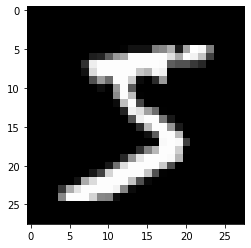

In [3]:
images = dataset.data.unsqueeze(-1).numpy().astype(np.float64)
print(images.shape)


first_image = images[0]
plt.imshow(first_image, cmap='gray')
plt.show()

In [4]:
labels = dataset.targets.numpy()

In [5]:
print("Processing images into graphs...", end="")
ptime = time.time()

with multiprocessing.Pool() as p:
    graphs = p.map(utils.get_graph_from_image, images[:1000])
    
data = []
for g in graphs:
    x, edge_index, centers = g
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    centers = torch.tensor(centers, dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, centers=centers)
    data.append(graph)
    
ptime = time.time() - ptime
print(" Took {ptime}s".format(ptime=ptime))

Processing images into graphs... Took 4.790640830993652s


In [6]:
print("Processing images into graphs...", end="")
ptime = time.time()

data = []
i = 0
for img in images[:1000]:
    x, edge_index, centers = utils.get_graph_from_image(first_image)

    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    centers = torch.tensor(centers, dtype=torch.float)

    graph = Data(x=x, edge_index=edge_index, centers=centers)
    data.append(graph)

    clear_output(wait=True)
    display('Iteration ' + str(i))
    i += 1
    
ptime = time.time() - ptime
print(" Took {ptime}s".format(ptime=ptime))

'Iteration 999'

 Took 12.384698152542114s


Data(centers=[77, 2], edge_index=[2, 472], x=[77, 3])


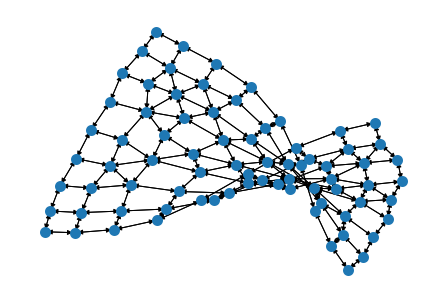

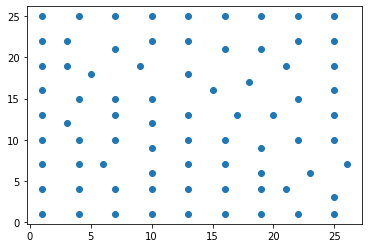

Data(centers=[77, 2], edge_index=[2, 472], x=[77, 3])


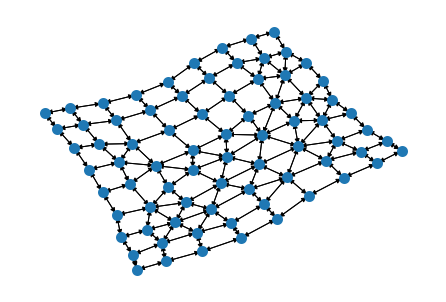

Number of graphs: 1000
Number of nodes: 77000
Number of edges: 472000
Number of node features: 3


In [18]:
graph_data = data[8]
print(graph_data)
G = to_networkx(graph_data, node_attrs=['x'])
nx.draw(G, cmap=plt.get_cmap('Set1'), node_size=25, linewidths=6)
plt.show()

plt.scatter(graph_data['centers'][:,0], graph_data['centers'][:,1])
plt.show()

graph_data = data[999]
print(graph_data)
G = to_networkx(graph_data, node_attrs=['x'])
nx.draw(G, cmap=plt.get_cmap('Set1'), node_size=25, linewidths=6)
plt.show()

batch = Batch.from_data_list(data)
print("Number of graphs:", batch.num_graphs)
print("Number of nodes:", batch.num_nodes)
print("Number of edges:", batch.num_edges)
print("Number of node features:", batch.num_node_features)
